In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
its = pd.read_csv('EMU.ITS.rel_abund.final.csv')
bacteria = pd.read_csv('EMU.16S.rel_abund.final.csv')
amf = pd.read_csv('EMU.18S.rel_abund.final.csv')
env_data = pd.read_csv('env_data.csv')

In [11]:
# Set new index for each DataFrame
def set_custom_index(df, kingdom):
    df['custom_index'] = kingdom + '_' + df['genus'].astype(str) + '_' + df['species'].astype(str)
    df.set_index('custom_index', inplace=True)
    sample_ids = env_data['sample_id'].astype(str).tolist()
    df = df[sample_ids].fillna(0)
    return df.T

its_data = set_custom_index(its, 'Fungi')
bacteria_data = set_custom_index(bacteria, 'Bacteria')
amf_data = set_custom_index(amf, 'AMF')

In [20]:
# Function to perform Random Forest with Grid Search
def random_forest_grid_search(data, labels, n_iter=3):
    avg_accuracy = []
    avg_feature_importance = np.zeros(data.shape[1])
    
    # Hyperparameters to tune
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
    
    for i in range(n_iter):
        # Data Splitting
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=i)
        
        # Initialize Random Forest Classifier
        rf = RandomForestClassifier()
        
        # Grid Search
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)
        grid_search.fit(X_train, y_train)
        
        # Best model
        best_model = grid_search.best_estimator_
        
        # Predict and Calculate Accuracy
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        avg_accuracy.append(accuracy)
        
        # Feature Importance
        feature_importance = best_model.feature_importances_
        avg_feature_importance += feature_importance
    
    avg_accuracy = np.mean(avg_accuracy)
    avg_feature_importance /= n_iter
    
    return avg_accuracy, avg_feature_importance

# Prepare labels
treatment_labels = env_data['Treatment']

# Calculate for each dataset
its_avg_accuracy, its_avg_feature_importance = random_forest_grid_search(its_data, treatment_labels)
bacteria_avg_accuracy, bacteria_avg_feature_importance = random_forest_grid_search(bacteria_data, treatment_labels)
amf_avg_accuracy, amf_avg_feature_importance = random_forest_grid_search(amf_data, treatment_labels)

# Convert feature importances to DataFrame for easier interpretation
its_feature_importance_df = pd.DataFrame({'Feature': its_data.columns, 'Importance': its_avg_feature_importance})
bacteria_feature_importance_df = pd.DataFrame({'Feature': bacteria_data.columns, 'Importance': bacteria_avg_feature_importance})
amf_feature_importance_df = pd.DataFrame({'Feature': amf_data.columns, 'Importance': amf_avg_feature_importance})

In [26]:
print('ITS accuracy: ', str(its_avg_accuracy))
print('Bacteria accuracy: ', str(bacteria_avg_accuracy))
print('AMF accuracy: ', str(amf_avg_accuracy))

ITS accuracy:  0.4444444444444444
Bacteria accuracy:  0.5555555555555556
AMF accuracy:  0.7222222222222223


In [30]:
amf_feature_importance_df.sort_values('Importance', ascending = False).head()

,Feature,Importance
25,AMF_UNK_Glomeraceae sp. 1,0.100067
36,AMF_Paraglomus_Paraglomus bolivianum,0.098564
10,AMF_Diversispora_Diversispora sp. 2,0.082671
8,AMF_Diversispora_Diversispora spurca,0.061934
33,AMF_Rhizophagus _Rhizophagus sp. 1,0.058607


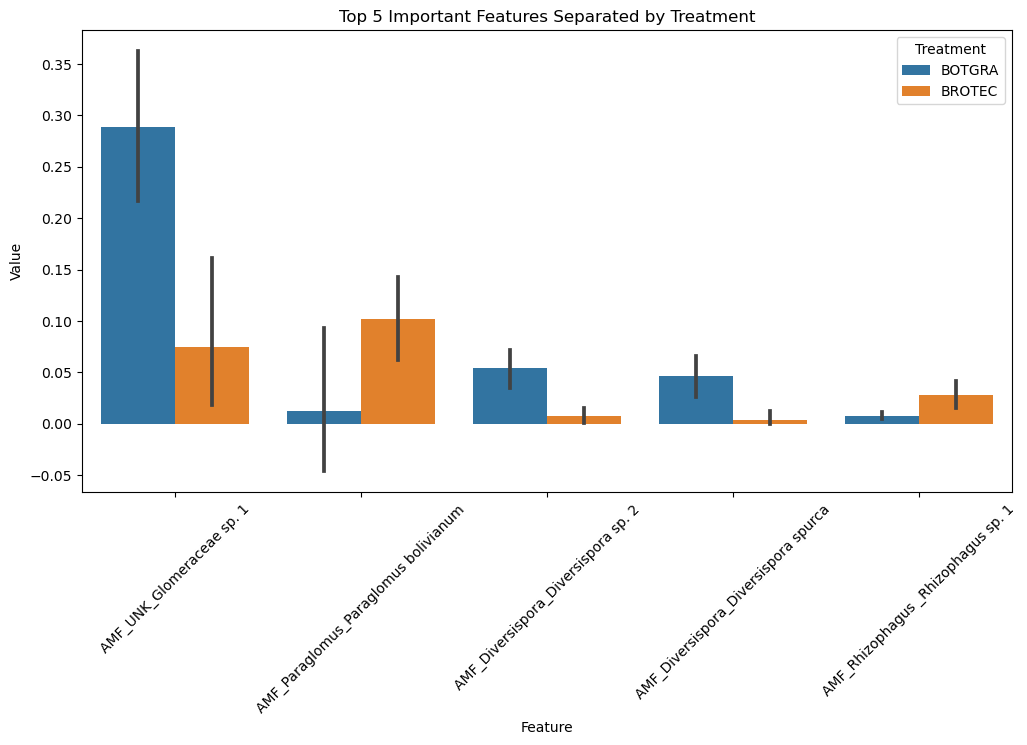

<Figure size 640x480 with 0 Axes>

In [41]:
# Reset the index of amf_data if it's an index
amf_data_reset = amf_data.reset_index()

# Filter the top 5 features
top_5_amf_data = amf_data_reset[top_5_features].copy()  # Create an explicit copy

# Add the 'Sample_ID' column to this filtered dataframe
top_5_amf_data['Sample_ID'] = amf_data_reset['Sample_ID'].astype(str)  # Ensuring data type consistency

# Convert 'sample_id' in env_data to string type to match 'Sample_ID'
env_data['sample_id'] = env_data['sample_id'].astype(str)

# Merge based on the common identifier 'sample_id' in env_data and 'Sample_ID' in top_5_amf_data
merged_data = pd.merge(env_data, top_5_amf_data, left_on='sample_id', right_on='Sample_ID')

# Melt the dataframe to prepare it for seaborn
melted_data = pd.melt(merged_data, id_vars=['Treatment'], value_vars=top_5_features, var_name='Feature', value_name='Value')

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_data, x='Feature', y='Value', hue='Treatment')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.title('Top 5 Important Features Separated by Treatment')
plt.xticks(rotation=45)
plt.show()
plt.savefig('abundance_differences_treatment_amf.jpg', bbox_inches = 'tight', dpi = 300)